<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

方法一

In [ ]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
!tar -xvf drive/MyDrive/cable.tar.gz cable

Mounted at /content/drive
tar: drive/MyDrive/cable.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
import cv2
import numpy as np
import glob
from tqdm import tqdm

# 讀取訓練集 (僅 good 類別)
train_paths = glob.glob('/content/drive/MyDrive/pill/pill/train/good/*.png')

# 讀取測試集 (包含 good + 異常類別)
test_paths = glob.glob('/content/drive/MyDrive/pill/pill/test/*/*.png')

# 合併 train + test 圖片路徑
file_paths = train_paths + test_paths

# 讀取所有圖片
all_data = []
for img_path in tqdm(file_paths):
    img = cv2.imread(img_path)  # 讀取圖片
    img = img[..., ::-1]  # BGR 轉 RGB
    all_data.append(img)

all_data = np.stack(all_data)
print(f"All data shape: {all_data.shape}")


100%|██████████| 434/434 [01:49<00:00,  3.96it/s]


All data shape: (434, 800, 800, 3)


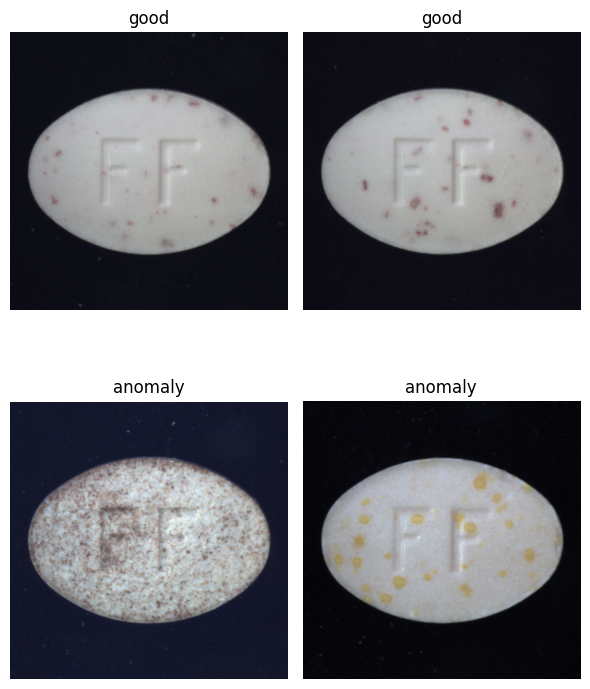

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# 建立標籤: 0 (good) / 1 (anomaly)
labels = []
for path in file_paths:
    if 'train/good' in path or 'test/good' in path:
        labels.append(0)  # good
    else:
        labels.append(1)  # anomaly

labels = np.array(labels)

# 取得 good 與 anomaly 的索引
good_indices = np.where(labels == 0)[0]
anomaly_indices = np.where(labels == 1)[0]

# 設定類別
classes = ['good', 'anomaly']

# 顯示圖片
fig, axs = plt.subplots(2, 2, figsize=(6, 8))  # 2 類別，每類別 2 張圖
for i, class_name in enumerate(classes):
    indices = good_indices if class_name == 'good' else anomaly_indices  # 選對應類別的索引
    for j in range(2):
        if j < len(indices):  # 避免索引超出範圍
            axs[i, j].set_title(f'{class_name}')
            axs[i, j].imshow(all_data[indices[j]])
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()


## A. Data Loading and Preprocessing

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# 建立標籤: 0 (good) / 1 (anomaly)
labels = []
for path in file_paths:
    if 'train/good' in path or 'test/good' in path:
        labels.append(0)  # good
    else:
        labels.append(1)  # anomaly

labels = np.array(labels)

# 分割訓練與驗證集
train_indices = [i for i, path in enumerate(file_paths) if 'train/good' in path]
val_indices = [i for i, path in enumerate(file_paths) if 'test/' in path]  # test 裡面有 good 和 anomaly

x_train = all_data[train_indices]
y_train = labels[train_indices]

x_val = all_data[val_indices]
y_val = labels[val_indices]

# 轉換成 PyTorch 格式: (batch, channels, height, width)
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_val = np.transpose(x_val, (0, 3, 1, 2))

print(f'Shape of x_train: {x_train.shape}')  # (num_train, C, H, W)
print(f'Shape of x_val: {x_val.shape}')      # (num_val, C, H, W)
print(f'Shape of y_train: {y_train.shape}')  # (num_train,)
print(f'Shape of y_val: {y_val.shape}')      # (num_val,)


Shape of x_train: (267, 3, 800, 800)
Shape of x_val: (167, 3, 800, 800)
Shape of y_train: (267,)
Shape of y_val: (167,)


In [ ]:
from sklearn.model_selection import train_test_split

# 建立標籤
labels = np.array([0 if 'good' in path else 1 for path in file_paths])

# 取得 good 和 anomaly 的索引
good_indices = [i for i, path in enumerate(file_paths) if 'good' in path]
anomaly_indices = [i for i, path in enumerate(file_paths) if 'good' not in path]

# 分割 good 和 anomaly 到 train / val
good_train_indices, good_val_indices = train_test_split(good_indices, test_size=0.3, random_state=42)
anomaly_train_indices, anomaly_val_indices = train_test_split(anomaly_indices, test_size=0.3, random_state=42)

# 訓練集：部分 good + 部分 anomaly
train_indices = good_train_indices + anomaly_train_indices
val_indices = good_val_indices + anomaly_val_indices  # 驗證集也包含一部分 good

# 取出訓練與驗證資料
x_train, y_train = all_data[train_indices], labels[train_indices]
x_val, y_val = all_data[val_indices], labels[val_indices]

# 轉換成 PyTorch 格式: (batch, channels, height, width)
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_val = np.transpose(x_val, (0, 3, 1, 2))

print("Train label distribution:", np.bincount(y_train))
print("Val label distribution:", np.bincount(y_val))


Train label distribution: [205  98]
Val label distribution: [88 43]


## B. Defining Neural Networks

## C. Training the Neural Network

In [ ]:

from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import datasets, transforms
import torch

import numpy as np
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # 裁到模型常見大小
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),  # 有些藥丸是直放的，可以加一點點
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),  # 色彩增強
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 和訓練輸入保持一致
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).float()  # **改成 float() 適應 BCE loss**
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))  # 轉換回 HWC 格式
        return self.transform(Image.fromarray(new_x)), self.y[idx]

# 設定 batch size
batch_size =32

# 創建 dataset 和 dataloader
train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

# 載入 ResNet18 預訓練模型
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

model = models.resnet50(weights='IMAGENET1K_V1')

# 固定 ResNet 的預訓練參數
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features

# **改成二元分類（num_class=1）**
model.fc = nn.Linear(num_ftrs, 1)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        """
        alpha: 控制正負類別權重 (0.25 代表正類較少，負類較多)
        gamma: 控制難分類樣本的權重 (越大，讓難分類樣本影響更大)
        reduction: 'mean' 平均損失, 'sum' 求和損失, 'none' 保持原 shape
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # 計算 pt
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss  # Focal Loss 計算

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
import torch.nn as nn
from torchvision import models

# 載入預訓練的 ResNet18
model = models.resnet50(weights='IMAGENET1K_V1')

# 只凍結前面幾層（保留 layer4 fine-tune）
for name, param in model.named_parameters():
    if "layer4" not in name:
        param.requires_grad = False

# 取得最後全連接層的輸入特徵數
num_ftrs = model.fc.in_features

# 修改分類頭（加一層隱藏層 + Dropout + ReLU）
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1)  # Binary classification → output logits
)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#新
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 計算類別權重
train_labels_numpy = np.concatenate([labels.cpu().numpy() for _, labels in train_loader])
class_weights_np = compute_class_weight("balanced", classes=np.array([0, 1]), y=train_labels_numpy)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

# 損失函數 (適用於二分類問題)
#criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # 使用 pos_weight 來平衡不均衡類別
#criterion = FocalLoss(alpha=0.25, gamma=1.5).to(device)
criterion = nn.BCEWithLogitsLoss()
# 優化器
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 學習率調整策略（使用 ReduceLROnPlateau）
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# 訓練紀錄
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 設定 AMP 以提高效率
scaler = torch.cuda.amp.GradScaler()

best_val_loss = float('inf')
best_val_acc = -1
epochs = 15

for epoch in tqdm(range(epochs)):
    # === Training ===
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device) / 255.0, labels.float().to(device)  # 正規化 & 轉換為 float

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # 使用 AMP 提升計算效能
            outputs = model(images).squeeze(1)  # 確保輸出 shape 為 (batch_size,)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # 預測時使用 sigmoid，並判斷 > 0.5 屬於異常
        train_predicted = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100.0 * train_correct / total_train_samples

    # === Validation ===
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device) / 255.0, labels.float().to(device)

            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total

    # Learning rate update (根據 validation loss)
    scheduler.step(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_binary.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, '
          f'Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f}, '
          f'Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-24-8c518b1af178>:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/15 [00:00<?, ?it/s]

<ipython-input-24-8c518b1af178>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用 AMP 提升計算效能


Epoch 1/15, Train loss: 0.5913, Train acc: 68.32%, Val loss: 6.8668, Val acc: 67.18%, Best Val loss: 6.8668, Best Val acc: 67.18%
Epoch 2/15, Train loss: 0.5778, Train acc: 74.26%, Val loss: 0.7564, Val acc: 67.18%, Best Val loss: 0.7564, Best Val acc: 67.18%
Epoch 3/15, Train loss: 0.4251, Train acc: 82.51%, Val loss: 1.1007, Val acc: 67.18%, Best Val loss: 0.7564, Best Val acc: 67.18%
Epoch 4/15, Train loss: 0.4036, Train acc: 80.20%, Val loss: 2.1564, Val acc: 32.82%, Best Val loss: 0.7564, Best Val acc: 67.18%
Epoch 5/15, Train loss: 0.3757, Train acc: 83.50%, Val loss: 0.9295, Val acc: 67.18%, Best Val loss: 0.7564, Best Val acc: 67.18%
Epoch 6/15, Train loss: 0.3710, Train acc: 86.14%, Val loss: 1.0007, Val acc: 67.18%, Best Val loss: 0.7564, Best Val acc: 67.18%
Epoch 7/15, Train loss: 0.2831, Train acc: 89.44%, Val loss: 0.9445, Val acc: 67.94%, Best Val loss: 0.7564, Best Val acc: 67.94%
Epoch 8/15, Train loss: 0.2981, Train acc: 87.46%, Val loss: 0.7463, Val acc: 69.47%, Best

### Visualizing model performance

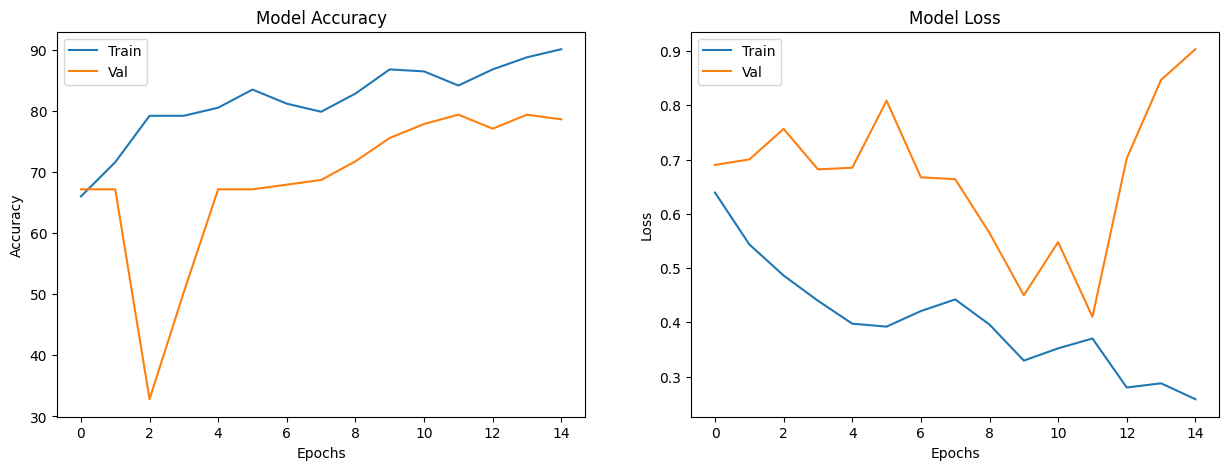

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('model_binary.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1,